# Формирование модели монетизации

**Презентация:**<BR>
https://drive.google.com/file/d/1Nfg0rHFP6KSm-s3FGCwPeDHw4_4g8vlN/view?usp=sharing

Для мобильной игры "Космические братья" нужно сформировать модель будущей монетизации. Она будет происходить в виде показа рекламы на экране с выбором типа объекта для постройки.<br>
Основная задача: определить на каких этапах игры показывать пользователям рекламу.

## Загрузка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
user_source = pd.read_csv('https://drive.google.com/uc?export=download&id=16xcZUycI88HTxG00fpOzoPA7Mz9zt6nk',
                           sep=',', encoding='windows-1251', low_memory=False)
events = pd.read_csv('https://drive.google.com/uc?export=download&id=1cvVWQ_Y5lYIib7OuMUUB3TRRkrN1WNND',
                           sep=',', encoding='windows-1251', low_memory=False)
ad_costs = pd.read_csv('https://drive.google.com/uc?export=download&id=122Jddsb-YzMsg1svcC2X5lSUiN0P3or7',
                           sep=',', encoding='windows-1251', low_memory=False)

## Предобработка

In [3]:
events['event_datetime'] = pd.to_datetime(events['event_datetime']).dt.to_period('D') 

In [4]:
finishes = ['not_finished', 'project', 'no_project']
def get_finish_type(row):
  finish_types = ['project', 'finished_stage_1']
  i=0
  for type in finish_types:
    i+=1
    if (events[events['user_id']==row['user_id']]['event'] == type).sum():
      return finishes[i]
  return finishes[0]

Соберем сводную таблицу по пользователям, дальше в основном будем анализоравть ее.

In [5]:
users = pd.DataFrame({'user_id':events['user_id'].unique()})
users['finish_type'] = users.apply(get_finish_type, axis=1)
users1 = events.pivot_table(columns='event', values='event_datetime',index='user_id', aggfunc='count').reset_index()
users2 = events.pivot_table(columns='building_type', values='event_datetime',index='user_id', aggfunc='count').reset_index()
users3 = events.pivot_table(values='event_datetime',index='user_id', aggfunc=['min', 'max']).reset_index()
users3.columns = ['user_id', 'start', 'finish']
users = users.merge(users1, on='user_id').merge(users2, on='user_id').merge(users3, on='user_id').merge(user_source, on='user_id')
users = users.drop(columns=['finished_stage_1', 'project'])
users['time'] = ( users['finish'].dt.to_timestamp() - users['start'].dt.to_timestamp() )/ np.timedelta64(1,'D')

In [6]:
users.head()

,user_id,finish_type,building,assembly_shop,research_center,spaceport,start,finish,source,time
0,55e92310-cb8e-4754-b622-597e124b03de,not_finished,7.0,7.0,NaN,NaN,2020-05-04,2020-05-10,youtube_channel_reklama,6.0
1,c07b1c10-f477-44dc-81dc-ec82254b1347,project,11.0,6.0,2.0,3.0,2020-05-04,2020-05-15,facebook_ads,11.0
2,6edd42cc-e753-4ff6-a947-2107cd560710,no_project,12.0,6.0,2.0,4.0,2020-05-04,2020-05-16,instagram_new_adverts,12.0
3,92c69003-d60a-444a-827f-8cc51bf6bf4c,not_finished,10.0,5.0,2.0,3.0,2020-05-04,2020-05-12,facebook_ads,8.0
4,cdc6bb92-0ccb-4490-9866-ef142f09139d,no_project,6.0,3.0,NaN,3.0,2020-05-04,2020-05-11,yandex_direct,7.0


In [7]:
events = events.merge(users[['user_id', 'finish_type']], on='user_id')

## Анализ

### EDA

In [8]:
print(f'Анализируемый период c {events["event_datetime"].min()} по {events["event_datetime"].max()} ')

Анализируемый период c 2020-05-04 по 2020-06-05 


In [9]:
print('Количество уникальных пользователей за период:', events['user_id'].nunique())

Количество уникальных пользователей за период: 13576


In [10]:
users['finish_type'].value_counts(), users['finish_type'].value_counts(normalize=True)

(not_finished    7759
 no_project      3951
 project         1866
 Name: finish_type, dtype: int64,
 not_finished    0.571523
 no_project      0.291028
 project         0.137448
 Name: finish_type, dtype: float64)

Из 1365 тыс. зарегистрированных пользователей до конца первого уровня дошли 57%. Посомтрим как они убывают.

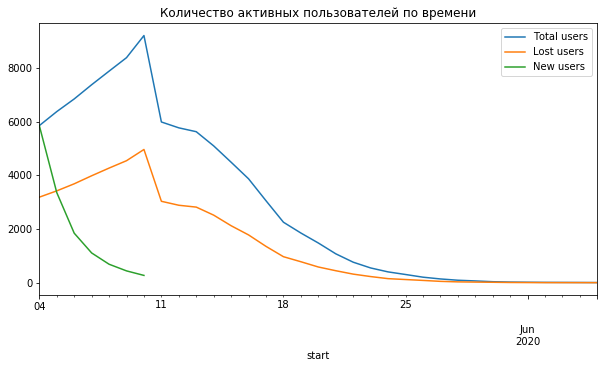

In [51]:
#print('\033[1m      Количетсво активных пользователей по времени')

fig, ax = plt.subplots(figsize=(10, 5))
events.groupby('event_datetime')['user_id'].nunique().reset_index().set_index('event_datetime').plot(ax=ax,legend='asd')
events[events['finish_type']=='not_finished'].groupby('event_datetime')['user_id'].nunique().reset_index().set_index('event_datetime').plot(ax=ax)

users.groupby('start')['user_id'].count().reset_index().set_index('start').plot(ax=ax)
ax.legend(['Total users', 'Lost users', 'New users'])
plt.title('Количество активных пользователей по времени')
plt.show()


Видим, что люди приходят и уходят со временем. Посомтрим по событиям.

In [12]:
df_list = {}
for i in range (1,22):
  df_list[i] = ( users[ (users['building']>=i)]['building'].count(),
                users[ (users['building']>=i) &  (users['finish_type']=='not_finished') ]['building'].count(),
                 users[ (users['building']>=i) &  (users['finish_type']!='not_finished') ]['building'].count(),
                users[ (users['building']<i) &  (users['finish_type']!='not_finished') ]['building'].count()
                )

In [13]:
fun = pd.DataFrame(df_list).T
fun.columns = ['all', 'not_finished', 'finished', 'finished_early']
##fun['all_diff'] = round(((fun['all'] / fun['all'].shift(1) ) * 100), 0)
#fun['not_finished_diff'] = round(((fun['not_finished'] / fun['not_finished'].shift(1) ) * 100), 0)
fun['finished_in_round'] = fun['finished_early'].shift(-1) - fun['finished_early']

fun['lost'] = fun['all'].max()- fun['all'] - fun['finished_early'] 
#fun['lost_in_round'] = fun['lost'] - fun['lost'].shift(1)
fun['lost_in_round'] = fun['lost'].shift(-1) - fun['lost']
fun['lost_in_round_pc'] = round((fun['lost_in_round'] / fun['all'] * 100),2)
fun['finished_in_round_pc'] = round((fun['finished_in_round'] / fun['all'] * 100),2)
print('\033[1m                                               Воронка по событиям')
fun

                                               Воронка по событиям


,all,not_finished,finished,finished_early,finished_in_round,lost,lost_in_round,lost_in_round_pc,finished_in_round_pc
1,13576,7759,5817,0,0.0,0,57.0,0.42,0.00
2,13519,7702,5817,0,49.0,57,229.0,1.69,0.36
3,13241,7473,5768,49,101.0,286,455.0,3.44,0.76
4,12685,7018,5667,150,168.0,741,614.0,4.84,1.32
5,11903,6404,5499,318,212.0,1355,779.0,6.54,1.78
6,10912,5625,5287,530,285.0,2134,1034.0,9.48,2.61
7,9593,4591,5002,815,75.0,3168,244.0,2.54,0.78
8,9274,4347,4927,890,357.0,3412,486.0,5.24,3.85
9,8431,3861,4570,1247,676.0,3898,638.0,7.57,8.02
10,7117,3223,3894,1923,846.0,4536,590.0,8.29,11.89


In [14]:
print(f'В среднем на каждой постройке теряется {round((fun["not_finished"].max() / users["building"].max()),0)} пользователей или {round((fun["all"].mean() / fun["not_finished"].max() / users["building"].max()*100),1)}% от пользователей, дошедших до этой постройки' )

В среднем на каждой постройке теряется 388.0 пользователей или 3.9% от пользователей, дошедших до этой постройки


              Количетсво активных пользователей по событиям


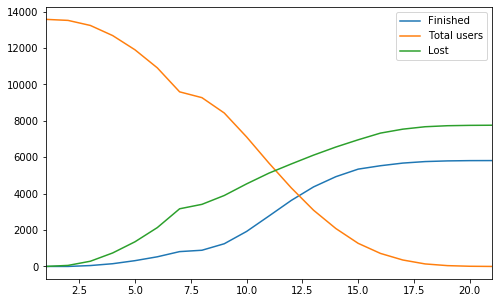

In [53]:
print('\033[1m              Количетсво активных пользователей по событиям')
fig, ax = plt.subplots(figsize=(8, 5))
fun['finished_early'].plot(ax=ax)
fun['all'].plot(ax=ax)
fun['lost'].plot(ax=ax)
ax.legend(['Finished', 'Total users', 'Lost'])
plt.show()

### Что влияет на прохождение уровня?

#### Источник пользователя

In [16]:
users_by_source = users.pivot_table(index='source', columns='finish_type', aggfunc='count')['finish'].reset_index()
users_by_source['tot'] = users_by_source['no_project'] + users_by_source['not_finished'] + users_by_source['project']
users_by_source['no_project'] = round(users_by_source['no_project'] / users_by_source['tot'] *100,0)
users_by_source['not_finished'] = round(users_by_source['not_finished'] / users_by_source['tot']  *100,0)
users_by_source['project'] = round(users_by_source['project'] / users_by_source['tot']  *100,0)

users_by_source

finish_type,source,no_project,not_finished,project,tot
0,facebook_ads,28.0,58.0,14.0,2726
1,instagram_new_adverts,30.0,56.0,14.0,3347
2,yandex_direct,30.0,58.0,13.0,4817
3,youtube_channel_reklama,29.0,57.0,14.0,2686


In [17]:
users.groupby('source').mean().reset_index()

,source,building,assembly_shop,research_center,spaceport,time
0,facebook_ads,9.585840,4.078136,1.867470,4.530405,10.676449
1,instagram_new_adverts,9.505527,4.012847,1.855719,4.543146,10.745145
2,yandex_direct,9.348557,4.005605,1.827306,4.422340,10.565497
3,youtube_channel_reklama,9.299702,3.965376,1.829499,4.472489,10.554356


Видим, что источник не влияет.

#### Порядок постройки строений

In [18]:
for i in range (1,21):
  users['build_{}'.format(i)]= events.groupby('user_id')['building_type'].nth(i).reset_index()['building_type'] 
  

Смотрим вторую и тертью постройку (первая у всех одинаковая):

In [19]:
for build in ('build_2', 'build_3'):
  users_by_source = users.pivot_table(index=build, columns='finish_type', aggfunc='count')['finish'].reset_index()
  users_by_source['tot'] = users_by_source['no_project'] + users_by_source['not_finished'] + users_by_source['project']
  users_by_source['no_project'] = round(users_by_source['no_project'] / users_by_source['tot'] *100,0)
  users_by_source['not_finished'] = round(users_by_source['not_finished'] / users_by_source['tot']  *100,0)
  users_by_source['project'] = round(users_by_source['project'] / users_by_source['tot']  *100,0)
  display(build)
  display(users_by_source)
  display(users.groupby('build_2').mean().reset_index())

'build_2'

finish_type,build_2,no_project,not_finished,project,tot
0,assembly_shop,29.0,57.0,14.0,8216
1,spaceport,30.0,57.0,14.0,5025


,build_2,building,assembly_shop,research_center,spaceport,time
0,assembly_shop,9.509250,4.071324,1.849742,4.495638,10.646787
1,spaceport,9.478408,4.082587,1.837457,4.459537,10.668856


'build_3'

finish_type,build_3,no_project,not_finished,project,tot
0,assembly_shop,30.0,56.0,14.0,6830
1,spaceport,29.0,56.0,15.0,5855


,build_2,building,assembly_shop,research_center,spaceport,time
0,assembly_shop,9.509250,4.071324,1.849742,4.495638,10.646787
1,spaceport,9.478408,4.082587,1.837457,4.459537,10.668856


Видим, что порядок постройки не влияет 


### На что влияет способ прохождения уровня?

Посмотрим как отличаются показатели прохождения уровня разных способов его прохождения.

In [20]:
users.groupby('finish_type').mean().reset_index()

,finish_type,building,assembly_shop,research_center,spaceport,time
0,no_project,9.411541,4.125032,1.603330,4.399589,11.058466
1,not_finished,8.657172,3.747906,1.930696,4.203587,9.746230
2,project,12.647910,4.885316,1.981243,5.781350,13.396570


In [79]:
y  = users['finish_type'].value_counts(normalize=True).reset_index()
y

,index,finish_type
0,not_finished,0.571523
1,no_project,0.291028
2,project,0.137448


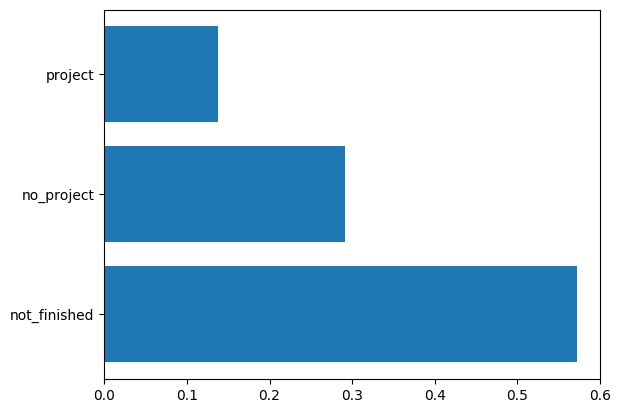

In [88]:
plt.rcdefaults()
fig, ax = plt.subplots()
plt.barh([1,2,3], width=y['finish_type'])
ax.set_yticks([1,2,3])
ax.set_yticklabels(y['index'])

plt.show()

57% пользователей не завершили первый уровень. Из тех, кто завершил, 70% сделали это победой над врагом

In [ ]:
ax.barh(y_pos, performance, xerr=error, align='center')

Время прохождения:

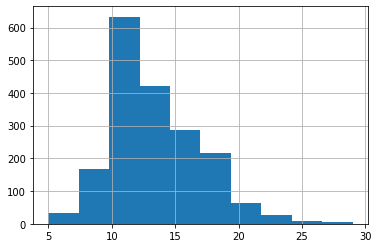

In [21]:
users[users['finish_type']=='project']['time'].hist()

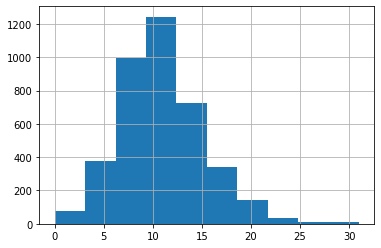

In [22]:
users[users['finish_type']=='no_project']['time'].hist()

In [23]:
users[users['finish_type']=='project']['time'].mean(), users[users['finish_type']=='no_project']['time'].mean(), users[users['finish_type']=='project']['time'].mean() - users[users['finish_type']=='no_project']['time'].mean()

(13.396570203644158, 11.0584662110858, 2.3381039925583575)

In [24]:

alpha = .05 
results = st.ttest_ind(
    users[users['finish_type']=='project']['time'], 
    users[users['finish_type']=='no_project']['time'],
    equal_var = False)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение: 6.570466755643636e-105
Отвергаем нулевую гипотезу


Среднее время прохождения уровня через реализацию проекта составляет 13,5 дней, что на 2 дня выше, чем время прохлждения, если победать врага. (Эта разница стат. значима)

Количество строений для прохождения уровня:

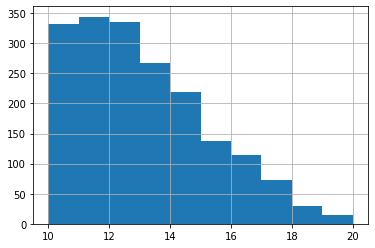

In [25]:
users[users['finish_type']=='project']['building'].hist()

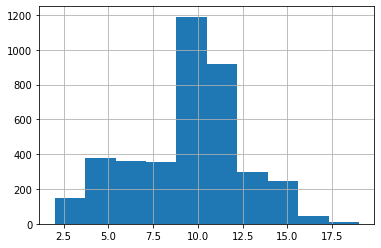

In [26]:
users[users['finish_type']=='no_project']['building'].hist()

In [27]:
users[users['finish_type']=='project']['building'].mean(), users[users['finish_type']=='no_project']['building'].mean(), users[users['finish_type']=='project']['building'].mean() - users[users['finish_type']=='no_project']['building'].mean()

(12.64790996784566, 9.411541381928625, 3.2363685859170346)

In [28]:
results = st.mannwhitneyu(
    users[users['finish_type']=='project']['building'], 
    users[users['finish_type']=='no_project']['building'])
print('p-значение:', results[1])
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение: 2.605963137511153e-305
Отвергаем нулевую гипотезу


Среднее количетсво построенных строений для прохождения уровня через реализацию проекта - 13, что на 3 выше, чем количество строений для прохлждения, если побеждать врага. (Эта разница стат. значима)

### Вывод

В данных активностей 13,5 тыс. пользователей на первом уровне игры за май 2020 г. мы увидели, что идет довольно большой отток пользователей - первый уровень заканчивают только 57% из них. При этом их поведение не зависит от места, из которого они пришли. Также нельзя определеить их последующее поведение по первым их шагам в игре.<br>
Большинство (70%) прошедших первый уровень пользователей проходят его победой над врагом. Это занимает меньше времени и требует именьше шагов, чем прохлждение уровня через реализацию проетка.<br>
К сожалению, из всего перечисленного нельзя сформулировать паттерны, по которым можно было бы определить по каким качественным правилам целесообразно включать / выключать рекламу. (За исклчюением одного: видно, что на 7-8 постройках у пользователей повышается интерес, уменьшается отток, поэтому целесообразно рекламу показывать на них)<br>
Потмоу модель будем строить более ориентрированную на количетсвенные показатели.

## Модель

Основной принцип такой: нужно получить максимальное количество просмотров рекламы пользователями за период их жизни (в т.ч. первый уровень).<br>
Общее количество просмотров будет определятсья следующим образом:<br><br>
`Кол-во просмотров` = SUMi(`Кол-во пользвателей на i постройке на первом уровне, на которой показывалась реклама`) + `Кол-во пользвателей, закончивших первый урвоень` * `Плановое количество просмотров рекламы, после первого уровня`<br><br>
Исходя из того, что при включении рекламы отток пользователей будет увеличиваться, решение не очевидно. При увеличении показов рекламы на первом уровне будет расти первое слагаемое, но уменьшаться второе (из-за снижения кол-ва прошедших урвоень), и наоборот.

Исходными данными для модели возьмем коэффициенты оттока и прохождения уровня на каждой постройке, а также первоначальное количество пользователей.<br>
Целевой переменной будет являться общее количество просмотров, достигать максимальне значение которой будем изменяя переменные-флаги наличия рекламы на каждом этапе постройки.<br>
Также нужно задаться коэффициентом увеличения оттока пользователя при включении рекламы и терминальынм количеством просмотров.

Закодим пока имеющиеся данные в модель:

In [29]:
model = fun[['lost_in_round_pc', 'finished_in_round_pc']]
model= model.loc[:20]
model.loc[1, 'all']=  fun['all'].max()
model['lost_in_round_pc_1'] = model['lost_in_round_pc']

for i in range (len(model)):
  model['lost'] = round( (model['all'] * model['lost_in_round_pc_1'] / 100), 0)
  model['finished'] = round( (model['all'] * model['finished_in_round_pc'] / 100), 0)
  model.loc[2:, 'all'] = model['all'].shift(1) - model['lost'].shift(1) - model['finished'].shift(1)
model['ad_tag'] = 0
model

,lost_in_round_pc,finished_in_round_pc,all,lost_in_round_pc_1,lost,finished,ad_tag
1,0.42,0.00,13576.0,0.42,57.0,0.0,0
2,1.69,0.36,13519.0,1.69,228.0,49.0,0
3,3.44,0.76,13242.0,3.44,456.0,101.0,0
4,4.84,1.32,12685.0,4.84,614.0,167.0,0
5,6.54,1.78,11904.0,6.54,779.0,212.0,0
6,9.48,2.61,10913.0,9.48,1035.0,285.0,0
7,2.54,0.78,9593.0,2.54,244.0,75.0,0
8,5.24,3.85,9274.0,5.24,486.0,357.0,0
9,7.57,8.02,8431.0,7.57,638.0,676.0,0
10,8.29,11.89,7117.0,8.29,590.0,846.0,0


Теперь добавим новые переменные и расчет общего колиечества просмотров:

In [30]:

def do_model(ad_churn_multiple, termination_ltv, ad_array):
    
  model['ad_tag'] = ad_array
  model['lost_in_round_pc_1'] = model['lost_in_round_pc'] * ad_churn_multiple
  for i in range (len(model)):
    model['lost'] = round( (model['all'] * model['lost_in_round_pc_1'] / 100), 0)
    model['finished'] = round( (model['all'] * model['finished_in_round_pc'] / 100), 0)
    model.loc[2:, 'all'] = model['all'].shift(1) - model['lost'].shift(1) - model['finished'].shift(1)
  tot_LTV = (model['ad_tag'] * model['all']).sum() + model['finished'].sum() * termination_ltv 
  display(model)
  print(tot_LTV)

In [31]:
do_model(ad_churn_multiple=1.5,
         termination_ltv=3,
         ad_array= [
         1,1,1,1,1,
         1,1,1,1,1,
         1,1,1,1,1,
         1,1,1,1,1         
         ])


,lost_in_round_pc,finished_in_round_pc,all,lost_in_round_pc_1,lost,finished,ad_tag
1,0.42,0.00,13576.0,0.630,86.0,0.0,1
2,1.69,0.36,13490.0,2.535,342.0,49.0,1
3,3.44,0.76,13099.0,5.160,676.0,100.0,1
4,4.84,1.32,12323.0,7.260,895.0,163.0,1
5,6.54,1.78,11265.0,9.810,1105.0,201.0,1
6,9.48,2.61,9959.0,14.220,1416.0,260.0,1
7,2.54,0.78,8283.0,3.810,316.0,65.0,1
8,5.24,3.85,7902.0,7.860,621.0,304.0,1
9,7.57,8.02,6977.0,11.355,792.0,560.0,1
10,8.29,11.89,5625.0,12.435,699.0,669.0,1


126963.0


Если миллион раз посчитать эту модель, то можно получить набор оптимальных значений переменных (порядковые номера построек, на которых нужно включать рекламу) для заданных сценариев (значения коэффициента увеличения оттока пользователя при включении рекламы и количеством просмотров после первого уровня).<br>
Сценарии сгенерируем комбинацией следующих переменных:
> средний и выскоий коээфициент увеличения оттока пользователей (1,5 и 2)<br>
> низкое, среднее, высокое и очень высокое кол-во терминальных просмотров (3, 10 ,50, 100)





Сведем все в итоговую таблицу:

In [32]:
#1
ad_churn_multiple = 1.5
termination_ltv = 3
name1 = str(ad_churn_multiple)+'/'+ str(termination_ltv)
ad_array1= [
1,1,1,1,1,
1,1,1,1,1,
1,1,1,1,1,
1,1,1,1,1
]

#2
ad_churn_multiple = 1.5
termination_ltv = 10
name2 = str(ad_churn_multiple)+'/'+ str(termination_ltv)
ad_array2= [
1,1,1,1,1,
1,1,1,1,1,
1,1,1,1,1,
1,1,1,1,1
]

#3
ad_churn_multiple = 1.5
termination_ltv = 50
name3 = str(ad_churn_multiple)+'/'+ str(termination_ltv)
ad_array3= [
1,1,1,1,1,
1,1,1,1,1,
0,0,0,0,0,
0,0,0,0,1
]

#4
ad_churn_multiple = 1.5
termination_ltv = 100
name4 = str(ad_churn_multiple)+'/'+ str(termination_ltv)
ad_array4= [
1,1,1,0,0,
0,1,0,0,0,
0,0,0,0,0,
0,0,0,0,1
]

#5
ad_churn_multiple = 2
termination_ltv = 3
name5 = str(ad_churn_multiple)+'/'+ str(termination_ltv)
ad_array5= [
1,1,1,1,1,
1,1,1,1,1,
1,1,1,1,1,
1,1,1,0,0
]

#6
ad_churn_multiple = 2
termination_ltv = 10
name6 = str(ad_churn_multiple)+'/'+ str(termination_ltv)
ad_array6= [
1,1,1,1,1,
1,1,1,1,1,
1,1,1,1,0,
0,0,0,0,1
]

#7
ad_churn_multiple = 2
termination_ltv = 50
name7 = str(ad_churn_multiple)+'/'+ str(termination_ltv)
ad_array7= [
1,1,1,0,0,
0,1,0,0,0,
0,0,0,0,0,
0,0,0,0,1
]

#8
ad_churn_multiple = 2
termination_ltv = 100
name8 = str(ad_churn_multiple)+'/'+ str(termination_ltv)
ad_array8= [
1,1,0,0,0,
0,0,0,0,0,
0,0,0,0,0,
0,0,0,0,1
]

In [33]:
res = pd.DataFrame({name1:ad_array1,
                    name2:ad_array2,
                    name3:ad_array3,
                    name4:ad_array4,
                    name5:ad_array5,
                    name6:ad_array6,
                    name7:ad_array7,
                    name8:ad_array8,})
res.index += 1 
res

,1.5/3,1.5/10,1.5/50,1.5/100,2/3,2/10,2/50,2/100
1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,0
4,1,1,1,0,1,1,0,0
5,1,1,1,0,1,1,0,0
6,1,1,1,0,1,1,0,0
7,1,1,1,1,1,1,1,0
8,1,1,1,0,1,1,0,0
9,1,1,1,0,1,1,0,0
10,1,1,1,0,1,1,0,0


Получается следующее:<br>
- при маленьком кол-ве (3 или 10) терминальных просмотров (если в игре после первого уровня почти нет контента) выгодно максимально монетизировать первый уровень - включать рекламу почти на каждой постройке
- при большом кол-ве (50-100) терминальных просмотров (если в игре после первого уровня  много контента) выгодно сохранить наибольшее количество пользователей после первого уровня и оставить рекламу толлько на первой половине построек, где она наиболее выгодна (низкий чарн и максимальное кол-во пользователей). Если отток пользоватлей увеличивается более сильно (к=2), то выгодно оставить рекламу только на первых двух постройках.<br><br>

Фактическое значение коэффициента увеличения оттока пользователя при включении рекламы для расчета можно получить после первой рекламной кампании, количество просмотров после первого уровня можно спрогнозировать по кол-ву контента в игре после первого уровня по сравнению с первым уровнем.

### Общий вывод

Задача была определить на каких этапах игры показывать пользователям рекламу.<br><br>
Для анализа взяли данные по когортам пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно. Увидели, что идет довольно большой отток пользователей - первый уровень заканчивают только 57% из них.
Большинство (70%) прошедших первый уровень пользователей проходят его победой над врагом. Это занимает меньше времени и требует именьше шагов, чем прохлждение уровня через реализацию проетка.<br><br>
Модель монетизации строили по критерию максимизации количества просмотров рекламы пользователями за период их жизни (в т.ч. первый уровень). Исходными данными коэффициента оттока и прохождения уровня на каждой постойке. По модели получили порядковые номера построек, на которых выгодно показывать рекламу, задаваясь при этом коэффициентом увеличения оттока из-за рекламы и количеством просмотренной рекламы после первого уровня.<br>

Фактическое значение коэффициента увеличения оттока пользователя при включении рекламы для расчета можно получить после первой рекламной кампании, количество просмотров после первого уровня можно спрогнозировать по кол-ву контента в игре после первого уровня по сравнению с первым уровнем.

### Рекомендации

При маленьком кол-ве (3 или 10) терминальных просмотров (если в игре после первого уровня почти нет контента) выгодно максимально монетизировать первый уровень - включать рекламу почти на каждой постройке<br>
При большом кол-ве (50-100) терминальных просмотров (если в игре после первого уровня много контента) выгодно сохранить наибольшее количество пользователей после первого уровня и оставить рекламу толлько на первой половине построек, где она наиболее выгодна (низкий чарн и максимальное кол-во пользователей). Если отток пользоватлей увеличивается более сильно (к=2), то выгодно оставить рекламу только на первых двух постройках.
<br>